# Basleine Efficientnet
In this notebook, we train an unpretrained reference model from Torchvision, efficientnet_v2_m, on our dataset and visualize the training curves along with the final model accuracy.

In [1]:
import torch
import os
import sys
import copy
import random
import time
import shutil
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
from torch.nn import Module,Linear,Sequential,ReLU,ELU,Dropout,BatchNorm1d,Flatten,Unflatten, CrossEntropyLoss
from torch.nn import Conv2d, MaxPool2d, BatchNorm2d, AdaptiveAvgPool1d, AdaptiveMaxPool1d
from torch.optim import lr_scheduler,SGD,Adam,AdamW,Adagrad,RMSprop
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
IMG_SIZE=224
DATA_FOLDER="/MAIN/files20/"
STD_LEN=512

In [4]:
import PIL
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}
batches={'train':32,'val':32}
full_dataset = datasets.ImageFolder(DATA_FOLDER)
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.2])
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
image_datasets={'train':train_dataset, 'val':val_dataset}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batches[x],
                                             shuffle=True, num_workers=10)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes
class_names =full_dataset.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

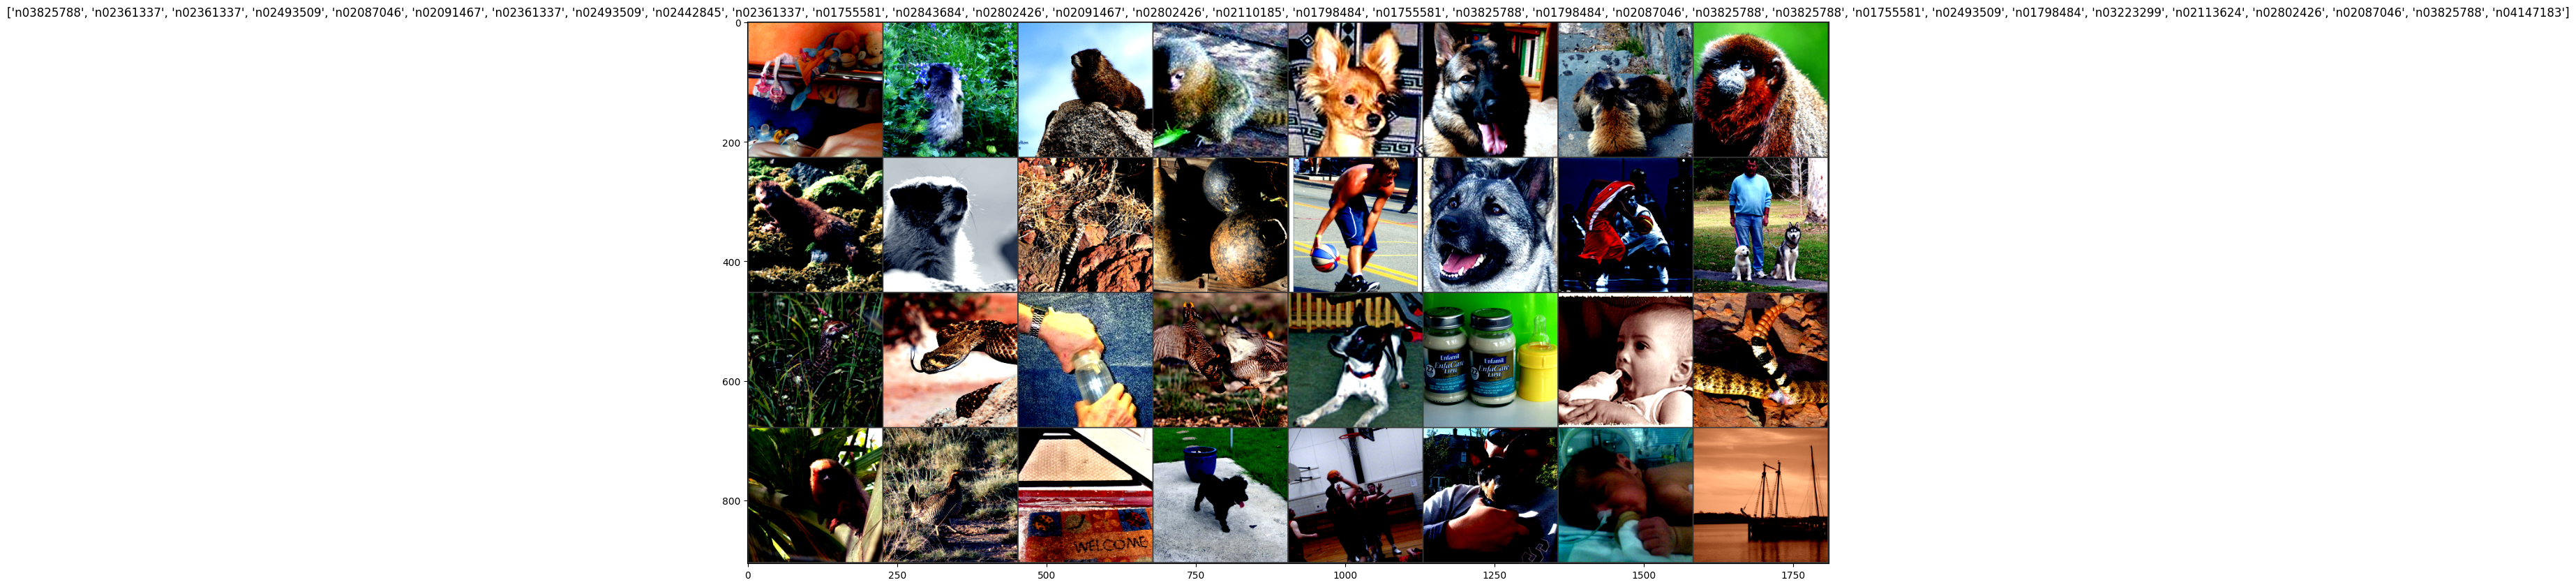

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    mean=  torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std= torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    inp = inp * mean
    inp = inp + std
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.imsave("dataset_samples.png",inp)
    plt.show()
    with open("dataset_samples.txt", "w") as output:
        output.write(str(title))
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(20,20))
imshow(out, title=[class_names[x] for x in classes])

#04

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch=0; best_acc = 0.0; best_loss = sys.maxsize
    hist_loss_train = []; hist_acc_train = [];
    hist_loss_val = []; hist_acc_val = []

    for epoch in range(num_epochs):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = running_corrects = 0
            # Iterate over data.
            cnt=0
            for inputs, labels in dataloaders[phase]:
                cnt += len(labels)
                with open("rnn_counters.txt", "w") as f:
                    f.write(f"{epoch}_{cnt}")
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            #     phase, epoch_loss, epoch_acc))
            if phase == 'train':
                hist_loss_train.append(float(epoch_loss))
                hist_acc_train.append(float(epoch_acc.cpu()))
            else:
                hist_loss_val.append(float(epoch_loss))
                hist_acc_val.append(float(epoch_acc.cpu()))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_acc = float(epoch_acc.cpu())
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
        # print()
        clear_output(True)
        print(f"epoch:{epoch} time:{(time.time() - since)/(epoch+1):.1f} acc:{hist_acc_val[-1]:.4f}")
        fig=plt.figure()
        plt.plot(np.arange(0,epoch+1),hist_loss_train,label='hist_loss_train')
        plt.plot(np.arange(0,epoch+1),hist_loss_val,label='hist_loss_val')
        plt.legend(framealpha=1, frameon=True);
        plt.title('Loss')
        plt.show()
        plt.plot(np.arange(0,epoch+1),hist_acc_train,label='hist_acc_train')
        plt.plot(np.arange(0,epoch+1),hist_acc_val,label='hist_acc_val')
        plt.legend(framealpha=1, frameon=True);
        plt.title('Acc')
        plt.show()
        # torch.save(model, f'rnn_conv_{epoch}.pth')
        
    model.eval()
    time_elapsed = time.time() - since
    
    dict_hist={
        "hist_loss_train": hist_loss_train,
        "hist_acc_train": hist_acc_train,
        "hist_loss_val": hist_loss_val,
        "hist_acc_val": hist_acc_val
    }
    # load best model weights
    model.load_state_dict(best_model_wts)
    model.eval()
    return model,best_acc,time_elapsed,fig,dict_hist

In [7]:
def prep_efficientnet():
    model = models.efficientnet_v2_m(weights=None)
    model.train()
    
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(num_ftrs, 512),
        nn.ELU(),
        nn.Dropout(p=0.3),
        nn.Linear(512, len(class_names)),  # class_names — список ваших меток
    )
    return model.to(device),'regnet'

In [8]:
model_ft,_=prep_efficientnet()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

epoch:34 time:251.1 acc:0.6845


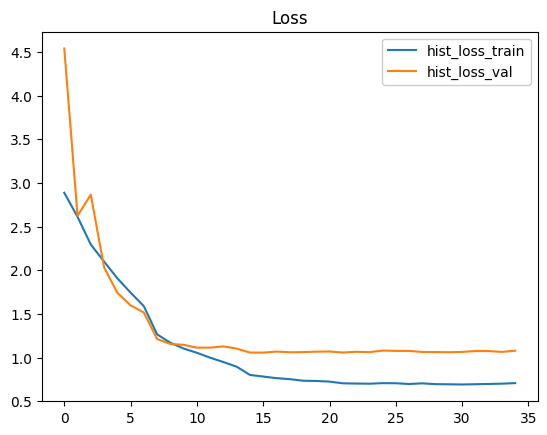

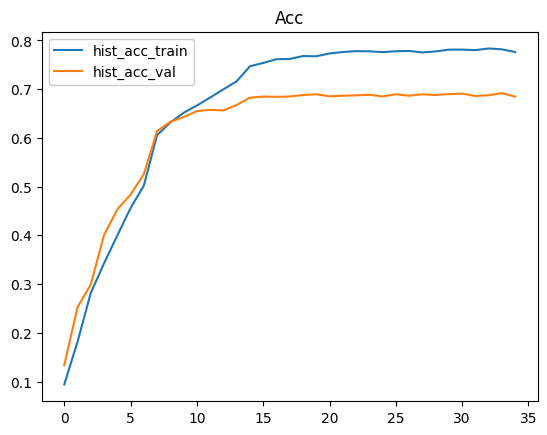

In [10]:
model,best_acc,time_elapsed,fig,dict_hist = train_model(model_ft, criterion, optimizer_ft,exp_lr_scheduler,num_epochs=35)